In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
import numpy as np
import tensorflow as tf
#import keras
import pandas as pd
#from keras_tqdm import TQDMNotebookCallback


In [39]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def data_generator(batch_size, tfrecord, start_frac=0, end_frac=1):
    '''
    Shuffles the Audioset training data and returns a generator of training data and boolean laughter labels
    batch_size: batch size for each set of training data and labels
    tfrecord: filestring of the tfrecord file to train on
    start_frac: the starting point of the data set to use, as a fraction of total record length (used for CV)
    end_frac: the ending point of the data set to use, as a fraction of total record length (used for CV)
    '''
    max_len=10
    records = list(tf.compat.v1.python_io.tf_record_iterator(tfrecord))
    records = records[int(start_frac*len(records)):int(end_frac*len(records))]
    rec_len = len(records)
    shuffle = np.random.permutation(range(rec_len))
    num_batches = rec_len//batch_size - 1
    j = 0

    laugh_labels = [66, 67] # changed to labels for cheer and applause
    while True:
        X = []
        y = []
        for idx in shuffle[j*batch_size:(j+1)*batch_size]:
            example = records[idx]
            tf_seq_example = tf.train.SequenceExample.FromString(example)
            example_label = list(np.asarray(tf_seq_example.context.feature['labels'].int64_list.value))
            laugh_bin = any((True for x in example_label if x in laugh_labels))
            y.append(laugh_bin)

            n_frames = len(tf_seq_example.feature_lists.feature_list['audio_embedding'].feature)
            audio_frame = []
            for i in range(n_frames):
                audio_frame.append(np.frombuffer(tf_seq_example.feature_lists.feature_list['audio_embedding'].
                                                         feature[i].bytes_list.value[0],np.uint8).astype(np.float32))
            pad = [np.zeros([128], np.float32) for i in range(max_len-n_frames)]
            audio_frame += pad
            X.append(audio_frame)

        j += 1
        if j >= num_batches:
            shuffle = np.random.permutation(range(rec_len))
            j = 0

        X = np.array(X)
        yield X, np.array(y)

### Logistic Regression

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten

lr_model = Sequential()
# lr_model.add(keras.Input((None, 128)))
lr_model.add(BatchNormalization(input_shape=(10, 128)))
lr_model.add(Flatten())
lr_model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
lr_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
batch_size=32

CV_frac = 0.1
train_gen = data_generator(batch_size,'../Data/bal_laugh_speech_subset.tfrecord', 0, 1-CV_frac)
val_gen = data_generator(128,'../Data/bal_laugh_speech_subset.tfrecord', 1-CV_frac, 1)

rec_len = 18768

lr_h = lr_model.fit_generator(train_gen,steps_per_epoch=int(rec_len*(1-CV_frac))//batch_size, epochs=100,
                       validation_data=val_gen, validation_steps=int(rec_len*CV_frac)//128,
                       verbose=0, callbacks=[TQDMNotebookCallback()])

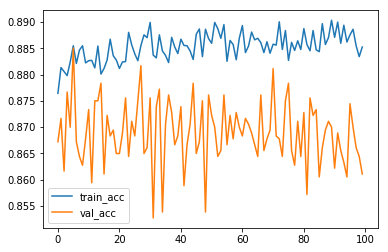

In [18]:
plt.plot(lr_h.history['acc'], label='train_acc')
plt.plot(lr_h.history['val_acc'], label='val_acc')
plt.legend()

In [19]:
lr_model.save('../Models/LogisticRegression_100Epochs.h5')

### Single Layer LSTM

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras import regularizers

lstm_model = Sequential()
lstm_model.add(BatchNormalization(input_shape=(None, 128)))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(128, activation='relu',
        kernel_regularizer=regularizers.l2(0.01),
        activity_regularizer=regularizers.l2(0.01)))
lstm_model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
lstm_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [20]:
batch_size=32

CV_frac = 0.1
train_gen = data_generator(batch_size,'../Data/bal_laugh_speech_subset.tfrecord', 0, 1-CV_frac)
val_gen = data_generator(128,'../Data/bal_laugh_speech_subset.tfrecord', 1-CV_frac, 1)

rec_len = 18768

lstm_h = lstm_model.fit_generator(train_gen,steps_per_epoch=int(rec_len*(1-CV_frac))//batch_size, epochs=100,
                       validation_data=val_gen, validation_steps=int(rec_len*CV_frac)//128,
                       verbose=0, callbacks=[TQDMNotebookCallback()])

KeyboardInterrupt: 

329/|/[loss: 0.301, acc: 0.896] :  62%|| 329/527 [00:28<00:08, 23.71it/s]

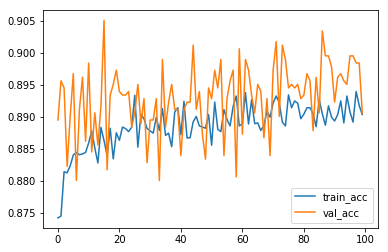

In [8]:
plt.plot(lstm_h.history['acc'], label='train_acc')
plt.plot(lstm_h.history['val_acc'], label='val_acc')
plt.legend()

In [9]:
lstm_model.save('../Models/LSTM_SingleLayer_100Epochs.h5')

### 3 Layer LSTM

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.layers import LSTM, TimeDistributed
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

lstm3_model = Sequential()
lstm3_model.add(BatchNormalization(input_shape=(None, 128)))
lstm3_model.add(Dropout(0.5))

lstm3_model.add(CuDNNLSTM(64, #activation='relu',
        kernel_regularizer=regularizers.l2(0.01),
        activity_regularizer=regularizers.l2(0.01),
        return_sequences=True))

lstm3_model.add(BatchNormalization())
lstm3_model.add(Dropout(0.5))

lstm3_model.add(CuDNNLSTM(64, #activation='relu',
        kernel_regularizer=regularizers.l2(0.01),
        activity_regularizer=regularizers.l2(0.01),
        return_sequences=True))

lstm3_model.add(BatchNormalization())
lstm3_model.add(Dropout(0.5))

lstm3_model.add(CuDNNLSTM(64, #activation='relu',
        kernel_regularizer=regularizers.l2(0.01),
        activity_regularizer=regularizers.l2(0.01)))

lstm3_model.add(Dense(1, activation='sigmoid'))

lstm3_model.summary()

# try using different optimizers and different optimizer configs
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
lstm3_model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_v2_25 (B (None, None, 128)         512       
_________________________________________________________________
dropout_25 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, None, 64)          49664     
_________________________________________________________________
batch_normalization_v2_26 (B (None, None, 64)          256       
_________________________________________________________________
dropout_26 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
cu_dnnlstm_7 (CuDNNLSTM)     (None, None, 64)          33280     
_________________________________________________________________
batch_normalization_v2_27 (B (None, None, 64)         

In [40]:
batch_size=32

CV_frac = 0.1
train_gen = data_generator(batch_size,'bal_laugh_speech_subset.tfrecord', 0, 1-CV_frac)
val_gen = data_generator(128,'bal_laugh_speech_subset.tfrecord', 1-CV_frac, 1)

rec_len = 12657 # find # of records in 'bal_laugh_speech_subset.tfrecord'
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
lstm3_model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
lstm3_model.fit_generator(train_gen,steps_per_epoch=int(rec_len*(1-CV_frac))//batch_size, epochs=100,
                       validation_data=val_gen, validation_steps=int(rec_len*CV_frac)//128,
                       verbose=1)

Epoch 1/100
355/355 [==============================] - 12s 35ms/step - loss: 2.5243 - accuracy: 0.6076 - val_loss: 1.8520 - val_accuracy: 0.8845
Epoch 2/100
355/355 [==============================] - 6s 18ms/step - loss: 1.9353 - accuracy: 0.8309 - val_loss: 1.7302 - val_accuracy: 0.9193
Epoch 3/100
355/355 [==============================] - 6s 17ms/step - loss: 1.8129 - accuracy: 0.8706 - val_loss: 1.6853 - val_accuracy: 0.9210
Epoch 4/100
355/355 [==============================] - 6s 17ms/step - loss: 1.7518 - accuracy: 0.8836 - val_loss: 1.6202 - val_accuracy: 0.9288
Epoch 5/100
355/355 [==============================] - 6s 17ms/step - loss: 1.7081 - accuracy: 0.8907 - val_loss: 1.6041 - val_accuracy: 0.9280
Epoch 6/100
355/355 [==============================] - 6s 17ms/step - loss: 1.6709 - accuracy: 0.8988 - val_loss: 1.5590 - val_accuracy: 0.9297
Epoch 7/100
355/355 [==============================] - 6s 17ms/step - loss: 1.6419 - accuracy: 0.9023 - val_loss: 1.5748 - val_accuracy

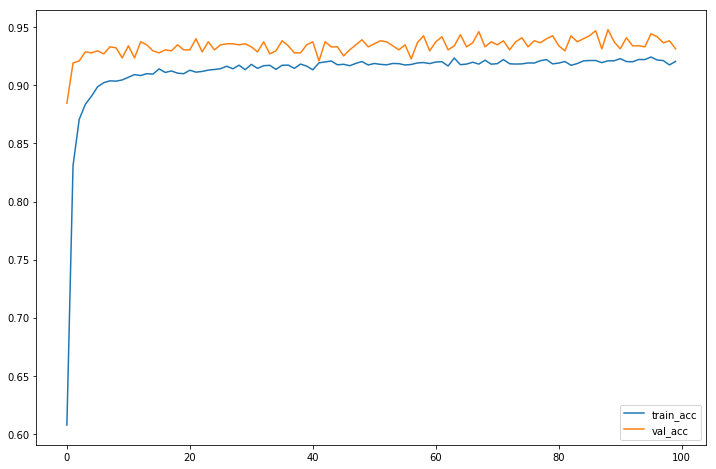

In [41]:
plt.plot(lstm3_model.history.history['accuracy'], label='train_acc')
plt.plot(lstm3_model.history.history['val_accuracy'], label='val_acc')
plt.legend()

In [42]:
lstm3_model.save('../Models/cheer_applause_LSTM_ThreeLayer_100Epochs.h5')

In [14]:
keras.__version__

'2.0.6'

In [33]:
from tensorflow.keras.callbacks import History

In [34]:
lstm3_model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])